## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
83.4MB [00:00, 136MB/s] 


In [4]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [6]:
#print the column names
for col in df.columns:
  print(col)

_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [7]:
#Assign new column names
df.rename(columns ={'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'source_tags', 
                    '_source.zip_code': 'source_zip_code', '_source.complaint_id': 'source_complaint_id',
                    '_source.complaint_id': 'source_complaint_id', '_source.issue': 'source_issue',
                    '_source.date_received': 'source_date_received', '_source.state': 'source_state',
                    '_source.consumer_disputed': 'source_consumer_disputed', '_source.product': 'source_product',
                    '_source.company_response': 'source_company_response', '_source.company': 'source_company',
                    '_source.submitted_via': 'source_submitted_via', '_source.date_sent_to_company': 'source_date_sent_to_company',
                    '_source.company_public_response': 'source_company_public_response', '_source.sub_product': 'source_sub_product',
                    '_source.timely': 'source_timely', '_source.complaint_what_happened': 'source_complaint_what_happened',
                    '_source.sub_issue': 'source_sub_issue', '_source.consumer_consent_provided': 'source_consumer_consent_provided'}, inplace = True)

In [8]:
#Assign nan in place of blanks in the complaints column
df[df['source_complaint_what_happened']== ''] = np.nan 

In [9]:
#Remove all rows where complaints column is nan
df = df[df['source_complaint_what_happened'].notnull()]

In [10]:
df.to_csv('df_new.csv', index=False)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower()
  pattern = re.compile('[\(\[].*?[\)\]]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[^\w\s]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[0-9]')
  text = re.sub(pattern, '', text)
  return text

In [12]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
#Write your function to Lemmatize the texts
def lemmatizer(text):      
    text = clean_text(text)  
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaints'] = df['source_complaint_what_happened'].apply(lambda x: clean_text(x))
df_clean['lemmatized_complaints'] = df['source_complaint_what_happened'].apply(lambda x: lemmatizer(x))


In [15]:
df_clean.to_csv('df_clean.csv', index=False)

In [16]:
#Write your function to extract the POS tags 
def pos_tag(text):
  doc = nlp(text)
  result = []
  for token in doc:
    if token.pos_ == 'NOUN':
      output = result.append(token.text)
      
  return ' '.join(result)


In [17]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] = df_clean['complaints'].apply(lambda x: pos_tag(x))

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




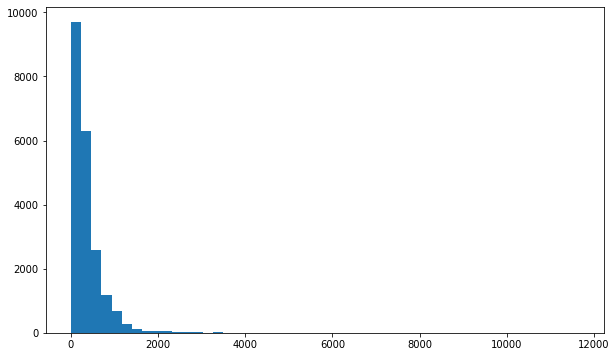

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

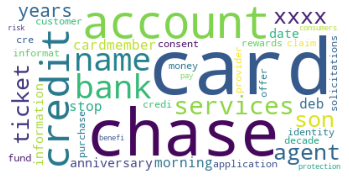

In [19]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))


wordcloud = WordCloud(stopwords=stoplist,max_words=40, background_color='white').generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();


In [20]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [21]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)

In [22]:
#Print the top 10 words in the unigram frequency
df_unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df_unigram.iloc[:10,:]

,unigram,count
0,account,40727
1,chase,36556
2,credit,31255
3,card,26117
4,bank,14401
5,payment,13690
6,xxxx,13423
7,money,11808
8,time,11695
9,information,9511


In [23]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)

In [24]:
#Print the top 10 words in the bigram frequency
df_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
df_bigram.iloc[:10,:]

,bigram,count
0,credit card,10532
1,credit report,3177
2,customer service,2790
3,chase credit,2541
4,account account,2327
5,chase account,2226
6,checking account,2145
7,account chase,2037
8,bank account,1869
9,credit cards,1850


In [25]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['complaints'], 30)

In [26]:
#Print the top 10 words in the trigram frequency
df_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df_trigram.iloc[:10,:]

,trigram,count
0,xxxx xxxx xxxx,37868
1,jp morgan chase,2284
2,chase credit card,1779
3,xxxx xxxx chase,1644
4,xxxxxxxx xxxx xxxx,1572
5,xxxx xxxx xxxxxxxx,1263
6,chase xxxx xxxx,1111
7,chase bank xxxx,1060
8,xxxx xxxxxxxx xxxx,954
9,account xxxx xxxx,908


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [29]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,xxxx ticket offer ticket rewards card informat...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit credit cards chase freedom xxxx problem...,credit credit cards chase freedom xxxx problem...


In [35]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [36]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit credit cards chase freedom xxxx problem...,credit credit cards chase freedom problems ba...


In [37]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaints             21072 non-null  object
 1   lemmatized_complaints  21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
dtypes: object(4)
memory usage: 823.1+ KB


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
# Transform word vector in tfidf vector
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
tfidf = vectorizer.fit_transform(df_clean.Complaint_clean) 


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
dtm

,aaaratings,abandonment,abatement,abide,abiding,abilities,ability,abs,absence,absolute,absurdity,abundance,abuse,abuser,abuses,ac,acc,acccount,acccounts,acceleration,accent,accents,accept,acceptance,access,accessibility,accessories,accessory,accident,accidents,accommodation,accommodations,accomplice,accomplices,accont,accord,accordance,according,accords,accou,...,wound,wrap,wreck,wrist,wristbands,writ,write,writeoff,writer,writers,writing,writings,wrong,wrongdoing,wrongdoings,wrongs,wthe,wwwchasecom,wwwconsumerfinancegov,xx,yard,yea,year,yearold,years,yeas,yesterday,yield,yields,yoga,youth,yr,yrs,ys,ytd,zeros,zip,zombie,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106607,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049531,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.047276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.065158,0.0,0.0,

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [40]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [41]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = 5, random_state = 100)

In [42]:
w=nmf_model.fit_transform(dtm)
len(vectorizer.get_feature_names())

7355

In [43]:
#Print the Top15 words for each of the topics
H = nmf_model.components_ 
words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,funds,chase,branch,checking,deposit,accounts,number,days,business,checks,fraud
Topic 2,credit,report,inquiry,inquiries,card,score,cards,accounts,account,debt,information,bureaus,limit,reports,reporting
Topic 3,loan,mortgage,home,modification,chase,property,payments,years,rate,house,letter,foreclosure,time,documents,sale
Topic 4,card,chase,charges,charge,credit,dispute,fraud,merchant,company,fee,transaction,purchase,phone,number,service
Topic 5,payment,payments,balance,month,fees,fee,statement,date,time,auto,days,account,chase,error,months


In [44]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

# Create a topic mapping
topic_mapping = {
    'Topic 1': 0,
    'Topic 2': 1,
    'Topic 3': 2,
    'Topic 4': 3,
    'Topic 5': 4,
}

In [45]:
#Assign the best topic to each of the cmplaints in Topic Column
w = pd.DataFrame(w, columns=[f'Topic {i + 1}' for i in range(num_topics )])
w['Topic'] = w.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
w=w[pd.notnull(w['Topic'])]
w

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic
0,0.023605,0.015176,0.014950,0.004671,0.009697,0
1,0.009070,0.001064,0.003089,0.020445,0.003306,3
2,0.000000,0.038306,0.000000,0.025009,0.000000,1
3,0.014789,0.057051,0.009736,0.016724,0.000000,1
4,0.067314,0.000000,0.001854,0.000000,0.000000,0
...,...,...,...,...,...,...
21067,0.003258,0.035431,0.000000,0.049812,0.022105,3
21068,0.010786,0.000000,0.008459,0.034446,0.000491,3
21069,0.012896,0.012630,0.005829,0.018284,0.000376,3
21070,0.000000,0.024994,0.000000,0.049978,0.119787,4


In [46]:
topic=pd.DataFrame(w['Topic'])
topic

,Topic
0,0
1,3
2,1
3,1
4,0
...,...
21067,3
21068,3
21069,3
21070,4


In [47]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit credit cards chase freedom xxxx problem...,credit credit cards chase freedom problems ba...


In [48]:
df_clean['C'] = np.arange(df_clean.shape[0])
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,C
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...,2
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...,3
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,4
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...,21067
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...,21068
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...,21069
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit credit cards chase freedom xxxx problem...,credit credit cards chase freedom problems ba...,21070


In [49]:
# setting first name as index column
df_clean.set_index("C", inplace = True)
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
C,,,,
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...
...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...


In [50]:
df_clean_new=df_clean.copy()
df_clean_new=pd.DataFrame(df_clean_new)
df_clean_new

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
C,,,,
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...
...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...


In [51]:
df_clean_new = pd.concat([df_clean_new, topic], axis=1, join='inner')
display(df_clean_new)

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...,0
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,3
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...,1
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...,1
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,0
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...,3
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...,3
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...,3
21070,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit credit cards chase freedom xxxx problem...,credit credit cards chase freedom problems ba...,4


In [52]:
#Print the first 5 Complaint for each of the Topics
df_clean_new1=df_clean_new.groupby('Topic').head(5)
df_clean_new1.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...,0
10,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account,account,0
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,0
12,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account code xxxxxxxx terms account deposit bo...,account code terms account deposit bonus days...,0
5,can you please remove inquiry,please remove inquiry,inquiry,inquiry,1
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...,1
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card data credit report company i...,chase credit card data credit report company i...,1
11,i have reached out to xxxx several times in at...,reached xxxx several time attempt fraudulent i...,times attempt inquiry creditor inquiry report ...,times attempt inquiry creditor inquiry report ...,1
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [53]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Bank Account services',1:'Credit card or prepaid card',2:'Mortgage/Loan' ,3:'Theft/Dispute Reporting',4:'Others'  }
#Replace Topics with Topic Names
df_clean_new['Topic'] = df_clean_new['Topic'].map(Topic_names)

In [54]:
df_clean_new

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...,Bank Account services
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Theft/Dispute Reporting
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...,Credit card or prepaid card
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...,Credit card or prepaid card
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,Bank Account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...,Theft/Dispute Reporting
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...,Theft/Dispute Reporting
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...,Theft/Dispute Reporting
21070,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit credit cards chase freedom xxxx problem...,credit credit cards chase freedom problems ba...,Others


In [55]:
df_clean_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 0 to 21071
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaints             21072 non-null  object
 1   lemmatized_complaints  21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
 4   Topic                  21072 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


In [56]:
df_clean_new.to_csv('df_clean_new.csv', index=False)

In [57]:
import pandas as pd
import numpy as np
df_clean_new=pd.read_csv('/content/df_clean_new.csv')

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [58]:
df_clean_new

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...,Bank Account services
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Theft/Dispute Reporting
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...,Credit card or prepaid card
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...,Credit card or prepaid card
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,Bank Account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...,Theft/Dispute Reporting
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...,Theft/Dispute Reporting
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...,Theft/Dispute Reporting
21070,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit credit cards chase freedom xxxx problem...,credit credit cards chase freedom problems ba...,Others


In [59]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data1=df_clean_new[['Complaint_clean','Topic']]
training_data1

,Complaint_clean,Topic
0,morning name stop bank cardmember services deb...,Bank Account services
1,card agent anniversary date agent information ...,Theft/Dispute Reporting
2,card application identity consent services cre...,Credit card or prepaid card
3,ticket offer ticket rewards card information ...,Credit card or prepaid card
4,son chase account fund bank account money son ...,Bank Account services
...,...,...
21067,chase card customer decade solicitations credi...,Theft/Dispute Reporting
21068,card provider claim purchase protection benefi...,Theft/Dispute Reporting
21069,pay risk consumers chase years banking merchan...,Theft/Dispute Reporting
21070,credit credit cards chase freedom problems ba...,Others


In [60]:
training_data=training_data1.copy()
training_data

,Complaint_clean,Topic
0,morning name stop bank cardmember services deb...,Bank Account services
1,card agent anniversary date agent information ...,Theft/Dispute Reporting
2,card application identity consent services cre...,Credit card or prepaid card
3,ticket offer ticket rewards card information ...,Credit card or prepaid card
4,son chase account fund bank account money son ...,Bank Account services
...,...,...
21067,chase card customer decade solicitations credi...,Theft/Dispute Reporting
21068,card provider claim purchase protection benefi...,Theft/Dispute Reporting
21069,pay risk consumers chase years banking merchan...,Theft/Dispute Reporting
21070,credit credit cards chase freedom problems ba...,Others


In [61]:
#Let's check the null value
training_data.isnull().sum()

Complaint_clean    8
Topic              0
dtype: int64

In [62]:
#Let's remove the empty text columns
training_data[training_data['Complaint_clean']=='']=np.nan

In [63]:
training_data.isnull().sum()

Complaint_clean    8
Topic              0
dtype: int64

In [64]:
#Let's remove the NAN values
training_data=training_data.dropna()
training_data.isnull().sum()

Complaint_clean    0
Topic              0
dtype: int64

In [65]:
#Now the data doesn't have NAN values
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21064 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Complaint_clean  21064 non-null  object
 1   Topic            21064 non-null  object
dtypes: object(2)
memory usage: 493.7+ KB


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [66]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code to get the Vector count
count_vect=CountVectorizer()
X=count_vect.fit_transform(training_data.Complaint_clean)
#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [67]:
# Write your code here to build any 3 models and evaluate them using the required metrics
#Create the dictionary of Topic names and Topics
Topic_names_new = {'Bank Account services':0,'Credit card or prepaid card':1,'Mortgage/Loan':2,'Theft/Dispute Reporting':3,'Others':4 }
#Replace Topics with Topic Names
training_data2 = training_data['Topic'].map(Topic_names_new)

In [68]:
y=training_data2
y

0        0
1        3
2        1
3        1
4        0
        ..
21067    3
21068    3
21069    3
21070    4
21071    4
Name: Topic, Length: 21064, dtype: int64

In [69]:
#import the libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt




**Spliting the data into train and test sets**

The original data was divided into features (X_tfidf) and target (y), which were then splitted into train (75%) and test (25%) sets.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [71]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15798, 16146)
(5266, 16146)
(15798,)
(5266,)


**Model building**

**Multinomial Naive Bayes**

In [72]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict, y_test)*100)

In [73]:
print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))

Naive Bayes Train Accuracy Score : 80% 
Naive Bayes Test Accuracy Score  : 77% 


In [74]:
target_category = training_data['Topic'].unique()
print(target_category)

['Bank Account services' 'Theft/Dispute Reporting'
 'Credit card or prepaid card' 'Others' 'Mortgage/Loan']


In [75]:
print(classification_report(test_predict, y_test, target_names=target_category))

                             precision    recall  f1-score   support

      Bank Account services       0.89      0.76      0.82      1659
    Theft/Dispute Reporting       0.65      0.88      0.75       650
Credit card or prepaid card       0.83      0.83      0.83       894
                     Others       0.90      0.69      0.78      1945
              Mortgage/Loan       0.19      0.96      0.32       118

                   accuracy                           0.77      5266
                  macro avg       0.69      0.82      0.70      5266
               weighted avg       0.84      0.77      0.79      5266



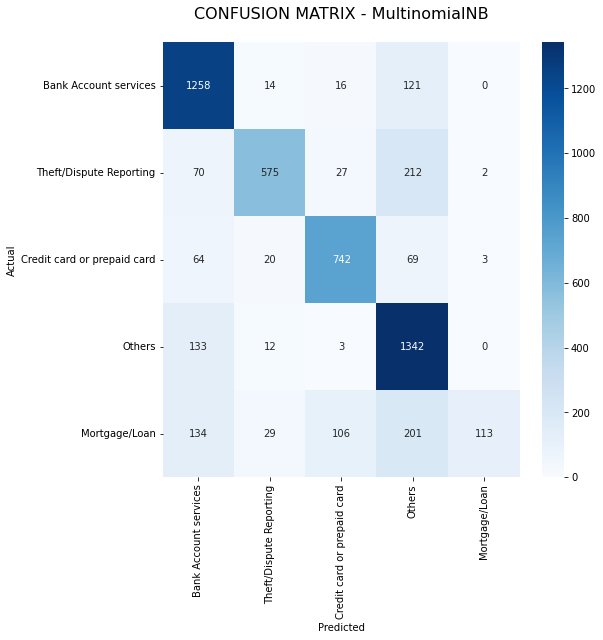

In [76]:
conf_mat = confusion_matrix(y_test, test_predict)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',xticklabels=target_category,yticklabels=target_category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - MultinomialNB\n", size=16);




**In general, the confusion matrix looks great (clear diagonal that represents correct classifications). Nevertheless, there are  some cases were the complaint was classified in a wrong class.**

**Decision Tree**

In [77]:
dt=DecisionTreeClassifier()
dt.fit(X_train, y_train)

test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict, y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 84% 



In [78]:
print(classification_report(test_predict, y_test, target_names=target_category))

                             precision    recall  f1-score   support

      Bank Account services       0.88      0.86      0.87      1450
    Theft/Dispute Reporting       0.81      0.79      0.80       908
Credit card or prepaid card       0.87      0.87      0.87       894
                     Others       0.82      0.85      0.84      1453
              Mortgage/Loan       0.76      0.79      0.77       561

                   accuracy                           0.84      5266
                  macro avg       0.83      0.83      0.83      5266
               weighted avg       0.84      0.84      0.84      5266



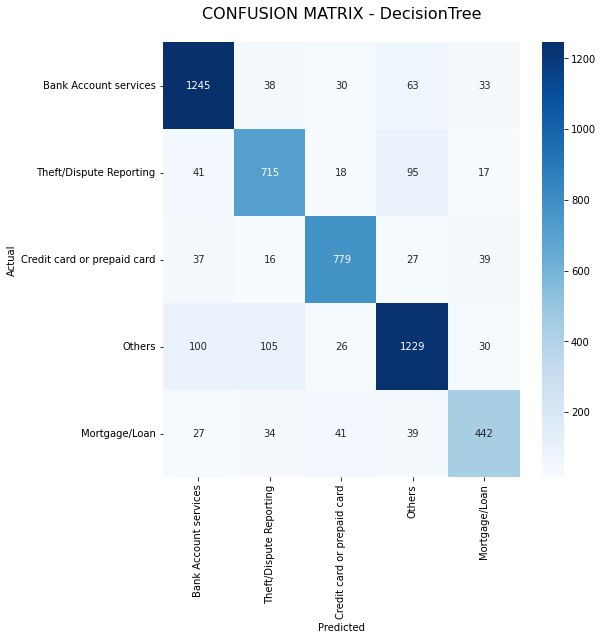

In [79]:
conf_mat = confusion_matrix(y_test, test_predict)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',xticklabels=target_category,yticklabels=target_category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - DecisionTree\n", size=16);

**In general, the confusion matrix looks great in decisonTree (clear diagonal that represents correct classifications). but there are some cases were the complaint was classified in a wrong class.**

**Random Forest Classifier**

In [80]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)

test_predict = rfc.predict(X_test)
train_accuracy = round(rfc.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict, y_test)*100)

print("Random Forest Classifier Train Accuracy Score : {}% ".format(train_accuracy ))
print("Random Forest Classifier Test Accuracy Score  : {}% ".format(test_accuracy ))
print()

Random Forest Classifier Train Accuracy Score : 100% 
Random Forest Classifier Test Accuracy Score  : 86% 



In [81]:
print(classification_report(test_predict, y_test, target_names=target_category))

                             precision    recall  f1-score   support

      Bank Account services       0.94      0.84      0.88      1581
    Theft/Dispute Reporting       0.84      0.87      0.85       855
Credit card or prepaid card       0.91      0.89      0.90       914
                     Others       0.89      0.83      0.86      1600
              Mortgage/Loan       0.51      0.94      0.66       316

                   accuracy                           0.86      5266
                  macro avg       0.82      0.87      0.83      5266
               weighted avg       0.88      0.86      0.86      5266



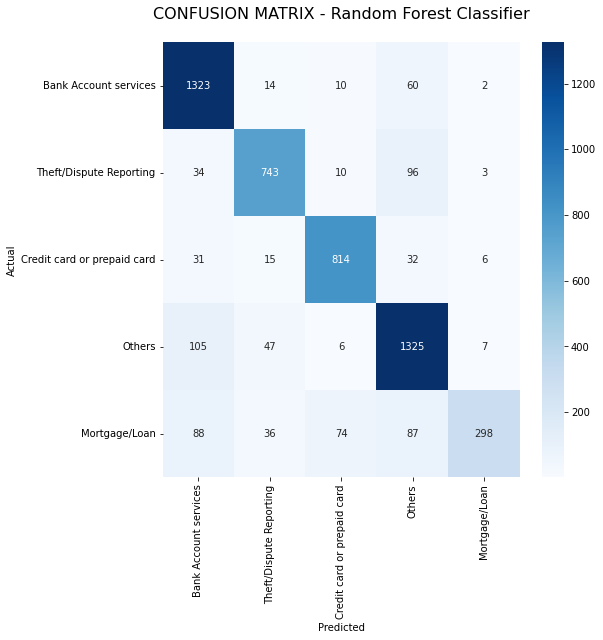

In [82]:
conf_mat = confusion_matrix(y_test, test_predict)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',xticklabels=target_category,yticklabels=target_category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest Classifier\n", size=16);

**In general, the confusion matrix looks great in Random Forest Classifier (clear diagonal that represents correct classifications). but there are some cases were the complaint was classified in a wrong class.**

**LogisticRegression**

In [83]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
test_predict = lr.predict(X_test)
train_accuracy = round(rfc.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict, y_test)*100)

print("LogisticRegression Train Accuracy Score : {}% ".format(train_accuracy ))
print("LogisticRegression Test Accuracy Score  : {}% ".format(test_accuracy ))
print()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression Train Accuracy Score : 100% 
LogisticRegression Test Accuracy Score  : 96% 



In [84]:
print(classification_report(test_predict, y_test, target_names=target_category))

                             precision    recall  f1-score   support

      Bank Account services       0.98      0.95      0.96      1450
    Theft/Dispute Reporting       0.94      0.97      0.95       854
Credit card or prepaid card       0.94      0.97      0.96       875
                     Others       0.98      0.94      0.96      1548
              Mortgage/Loan       0.90      0.97      0.94       539

                   accuracy                           0.96      5266
                  macro avg       0.95      0.96      0.95      5266
               weighted avg       0.96      0.96      0.96      5266



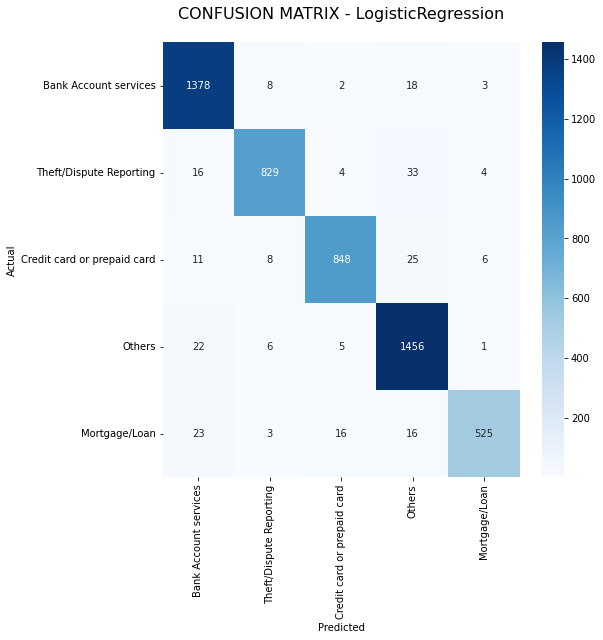

In [85]:
conf_mat = confusion_matrix(y_test, test_predict)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',xticklabels=target_category,yticklabels=target_category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

**Overall Conclusions**

Logistic regression produced the best prediction results followed by RandomForest classifier.

**Testing with Logistic regression**

In [86]:
Text="During the summer months, I experience a decline income due to my employment. Therefore, I request a one month payment extension with my Auto Loan Company, Chase. For the past almost fours years, my request for payment extension is granted. I have never been delinquent with my auto loan payment. However, On XX/XX/2019 my request for a one month payment extension was denied this year. I explained my situation to representative and the supervisor with no avail. After a lengthy discussion and waiting, I was informed the reason for the decline as it is not  contractual ''. This reason for denial baffled me and therefore I emailed the office of XXXX XXXX Executive Director, Communications, JPMorgan Chase & Co. A representative contacted me and stated Chase will follow-up. About week later a representative of XXXX XXXX XXXX XXXX office called. The representative shared her role was help resolve the matter. The representative via conference call contacted the department handing my request. After, reviewing my information my request was still denied based on  policy changes ''. I requested an explanation and representative stated a letter will be mailed with explanation. I have received XXXX letters the reason for denial was not  policy changes ''. I would like CFPB help in exploring the denial of my payment extension request especially since I have been clear reason for denial."

In [87]:
Text

"During the summer months, I experience a decline income due to my employment. Therefore, I request a one month payment extension with my Auto Loan Company, Chase. For the past almost fours years, my request for payment extension is granted. I have never been delinquent with my auto loan payment. However, On XX/XX/2019 my request for a one month payment extension was denied this year. I explained my situation to representative and the supervisor with no avail. After a lengthy discussion and waiting, I was informed the reason for the decline as it is not  contractual ''. This reason for denial baffled me and therefore I emailed the office of XXXX XXXX Executive Director, Communications, JPMorgan Chase & Co. A representative contacted me and stated Chase will follow-up. About week later a representative of XXXX XXXX XXXX XXXX office called. The representative shared her role was help resolve the matter. The representative via conference call contacted the department handing my request. A

In [88]:
Text=lemmatizer(Text)
Text

'summer month experience decline income due employment therefore request one month payment extension auto loan company chase past almost four year request payment extension granted never delinquent auto loan payment however xxxx request one month payment extension denied year explained situation representative supervisor avail lengthy discussion waiting informed reason decline contractual reason denial baffled therefore emailed office xxxx xxxx executive director communication jpmorgan chase co representative contacted stated chase followup week later representative xxxx xxxx xxxx xxxx office called representative shared role help resolve matter representative via conference call contacted department handing request reviewing information request still denied based policy change requested explanation representative stated letter mailed explanation received xxxx letter reason denial policy change would like cfpb help exploring denial payment extension request especially since clear reaso

In [89]:
Text = Text.replace('xxxx','')
Text

'summer month experience decline income due employment therefore request one month payment extension auto loan company chase past almost four year request payment extension granted never delinquent auto loan payment however  request one month payment extension denied year explained situation representative supervisor avail lengthy discussion waiting informed reason decline contractual reason denial baffled therefore emailed office   executive director communication jpmorgan chase co representative contacted stated chase followup week later representative     office called representative shared role help resolve matter representative via conference call contacted department handing request reviewing information request still denied based policy change requested explanation representative stated letter mailed explanation received  letter reason denial policy change would like cfpb help exploring denial payment extension request especially since clear reason denial'

In [90]:
Text=pos_tag(Text)
Text

'summer month experience decline income employment month payment company chase year request payment extension auto loan payment request month payment extension year situation representative supervisor avail discussion reason reason denial office director chase followup week representative office representative role help matter representative conference call handing request information request policy change explanation representative letter explanation letter reason denial policy change cfpb help payment extension reason denial'

In [91]:
test_text_new = Text
test_text_new

'summer month experience decline income employment month payment company chase year request payment extension auto loan payment request month payment extension year situation representative supervisor avail discussion reason reason denial office director chase followup week representative office representative role help matter representative conference call handing request information request policy change explanation representative letter explanation letter reason denial policy change cfpb help payment extension reason denial'

In [92]:
x1=training_data.Complaint_clean
x1

0        morning name stop bank cardmember services deb...
1        card agent anniversary date agent information ...
2        card application identity consent services cre...
3         ticket offer ticket rewards card information ...
4        son chase account fund bank account money son ...
                               ...                        
21067    chase card customer decade solicitations credi...
21068    card provider claim purchase protection benefi...
21069    pay risk consumers chase years banking merchan...
21070    credit credit cards chase freedom  problems ba...
21071    years accounts order line credit account payme...
Name: Complaint_clean, Length: 21064, dtype: object

In [93]:
X_train, X_test, y_train, y_test = train_test_split(x1, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train).toarray()

model = rfc.fit(tfidf_vectorizer_vectors, y_train)

In [94]:
tfidf_vectorizer_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:
print(model.predict(fitted_vectorizer.transform([test_text_new])))

[2]


In [96]:
Topic_names_new = {'Bank Account services':0,
                   'Credit card or prepaid card':1,
                   'Mortgage/Loan':2,
                   'Theft/Dispute Reporting':3,
                   'Others':4 }

In [98]:
Text_1="I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me."
Text_1

'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.'

In [99]:
Text_1=lemmatizer(Text_1)
Text_1

'upgraded xxxx xxxx card xxxx told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled'

In [103]:
Text_1 = Text_1.replace('xxxx','')
Text_1

'upgraded   card  told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account  changed anniversary date   without consent  recording agent misled'

In [104]:
Text_1=pos_tag(Text_1)
Text_1

'card agent anniversary date agent information order account anniversary date consent recording agent'

In [105]:
print(model.predict(fitted_vectorizer.transform([Text_1])))

[3]


In [106]:
Topic_names_new = {'Bank Account services':0,
                   'Credit card or prepaid card':1,
                   'Mortgage/Loan':2,
                   'Theft/Dispute Reporting':3,
                   'Others':4 }